## Loading dependencies

We are going to make use of __NLTK__ for processing the messages, __WordCloud__ and __matplotlib__ for visualization and __pandas__ for loading data, __NumPy__ for generating random probabilities for train-test split

In [85]:
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import pickle
import datetime
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stop = stopwords.words('english')
import os
from nltk.tokenize import word_tokenize 
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [84]:
from string import punctuation

## UDF:

In [147]:
def preprocess(sentence,lower_case=True,stem=True,stopwords=True,punctuations=True,gram=2):
    if lower_case:
        sentence = sentence.lower()
    word_tokens = word_tokenize(sentence)
    
    if stopwords:
        words = [w for w in word_tokens if not w in stop]
    
    if punctuations:
        words = [word.lower() for word in words if word.isalpha()]
    
    if stem:
        stemm = PorterStemmer()
        words = [stemm.stem(word) for word in words]
        
    return " ".join(words)


def show_wordcloud(data,text,**kwargs):
    if "spam" in kwargs.keys():
        if kwargs['spam']:
            corpus =" ".join(list(data.loc[data.Target==1,text]))
    elif "ham" in kwargs.keys():
        if kwargs['ham']:
            corpus =" ".join(list(data.loc[data.Target==0,text]))
    else:
        corpus =" ".join(list(data[Text]))
    spam_wc = WordCloud().generate(corpus)
    plt.figure(figsize=(10,8))
    plt.imshow(spam_wc)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

### Loading Data:
We do not require the columns ‘Unnamed: 2’, ‘Unnamed: 3’ and ‘Unnamed: 4’, so we remove them. We rename the column ‘v1’ as ‘label’ and ‘v2’ as ‘message’. 

In [156]:
data = pd.read_csv("spam.csv",encoding='latin-1')
data = data[["v1","v2"]]
data.rename(columns={"v1":"Target","v2":"Message"},inplace=True)

In [157]:
data.shape

(5572, 2)

### Preprocessing:

In [158]:
data.head()

,Target,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


* __‘ham’__ is replaced by 0 and __‘spam’__ is replaced by 1 in the ‘Target’ column. Finally we obtain the following dataframe.

In [159]:
le =LabelEncoder()
data.Target = le.fit_transform(data.Target)

In [160]:
data.head()

,Target,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Text Preprocessing: 

* Before starting with training we must preprocess the messages. First of all, we shall make all the character lowercase. 
* This is because **‘free’** and **‘FREE’** mean the same and we do not want to treat them as two different words.

* Then we tokenize each message in the dataset. **Tokenization** is the task of splitting up a message into pieces and throwing away the punctuation 

* The words like ‘go’, ‘goes’, ‘going’ indicate the same activity. We can replace all these words by a single word ‘go’. This is called **stemming**

* We then move on to remove the **stop words**. 
* Stop words are those words which occur extremely frequently in any text. 
     * For example words like ‘the’, ‘a’, ‘an’, ‘is’, ‘to’ etc. These words do not give us any information about the content of the text.
* Thus it should not matter if we remove these words for the text.

**Optional**: You can also use **n-grams** to improve the accuracy. As of now, we only dealt with 1 word. But when two words are together the meaning totally changes. For example, ‘good’ and ‘not good’ are opposite in meaning. Suppose a text contains ‘not good’, it is better to consider ‘not good’ as one token rather than ‘not’ and ‘good’. Therefore, sometimes accuracy is improved when we split the text into tokens of two (or more) words than only word.

In [161]:
data["Message"]=data["Message"].apply(preprocess)

In [162]:
data.head()

,Target,Message
0,0,go jurong point avail bugi n great world la e ...
1,0,ok lar joke wif u oni
2,1,free entri wkli comp win fa cup final tkt may ...
3,0,u dun say earli hor u c alreadi say
4,0,nah think goe usf live around though


### EDA:

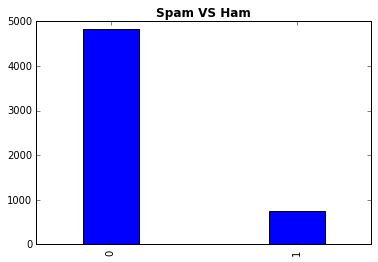

In [163]:
pd.value_counts(data.Target).plot("bar",color="blue",width=0.3)
plt.title("Spam VS Ham",weight="bold")
plt.show()

In [164]:
X= data.Message
y=data.Target

## Visualizing data

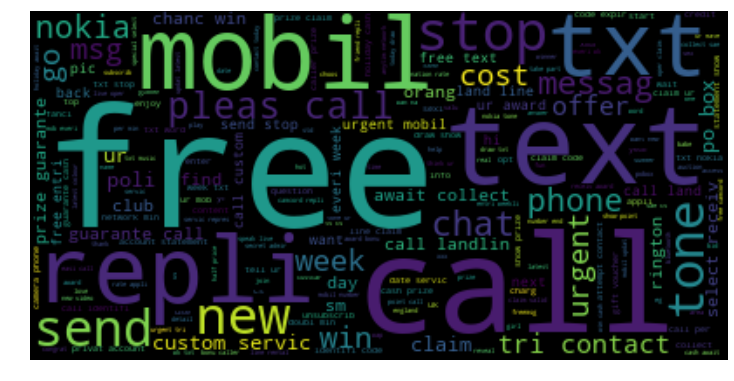

In [165]:
show_wordcloud(data,"Message",spam=True)

As expected, these messages mostly contain the words like ‘FREE’, ‘call’, ‘text’, ‘ringtone’, ‘prize claim’ etc

Similarly the wordcloud of ham messages is as follows:

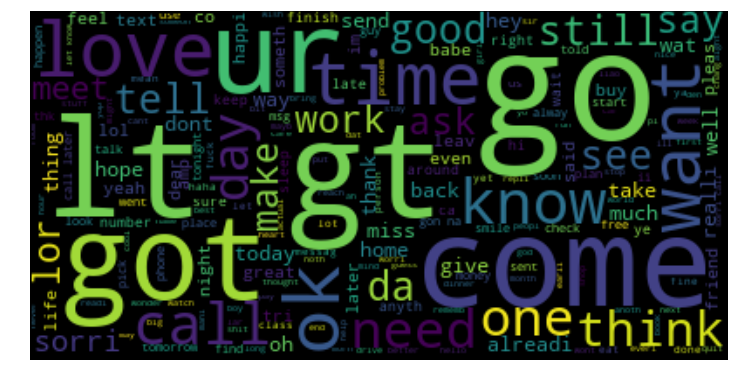

In [166]:
show_wordcloud(data,"Message",ham=True)

## Tf-Idf:

__Bag of Words:__ In Bag of words model we find the ‘term frequency’, i.e. number of occurrences of each word in the dataset. Thus for word w,

<img src="https://cdn-images-1.medium.com/max/800/1*k5hw9fat8QqCxhslpfyTpw.png"></img>

or

<img src="https://cdn-images-1.medium.com/max/800/1*wArU3CMFB9kqhQaZUYt-1w.png"></img>

__TF-IDF:__ TF-IDF stands for Term Frequency-Inverse Document Frequency. In addition to Term Frequency we compute Inverse document frequency.

<img src="https://cdn-images-1.medium.com/max/800/1*WHwfRvjRyHEH5kPOom9bOg.png"></img>

For example, there are two messages in the dataset. __‘hello world’__ and __‘hello foo bar’__. TF(‘hello’) is 2. IDF(‘hello’) is log(2/2). __If a word occurs a lot, it means that the word gives less information.__

In [167]:
tf_idf = TfidfVectorizer()
X=tf_idf.fit_transform(X)

## Splitting into Train & Test

In [168]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.15, random_state=42)

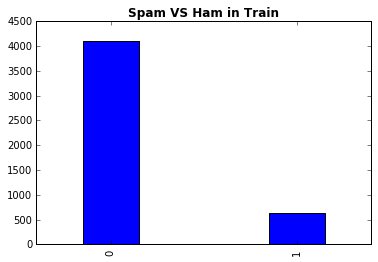

In [169]:
pd.value_counts(y_train).plot("bar",color="blue",width=0.3)
plt.title("Spam VS Ham in Train",weight="bold")
plt.show()

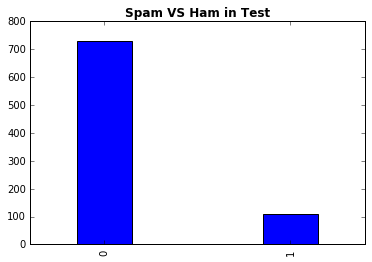

In [170]:
pd.value_counts(y_test).plot("bar",color="blue",width=0.3)
plt.title("Spam VS Ham in Test",weight="bold")
plt.show()

## Training the model

In [172]:
NavieModel = MultinomialNB()

In [173]:
NavieModel.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [175]:
NavieModel.predict(X_test)[0:5]

array([0, 0, 0, 0, 1], dtype=int64)

In [176]:
predictions= NavieModel.predict(X_test)

## Evaluation

In [177]:
confusion_matrix(y_test,predictions)

array([[728,   0],
       [ 25,  83]], dtype=int64)

In [178]:
accuracy_score(y_test,predictions)

0.9700956937799043

In [179]:
accuracy_score(y_test,predictions)

0.9700956937799043

### Final Testing

In [180]:
message = "Hi this is a spam Email.Please respond"

In [182]:
message = preprocess(message)

In [187]:
message

'hi spam respond'

In [184]:
tf_idf = TfidfVectorizer()

In [189]:
tf_idf.fit([message])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)